In [62]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck_clean.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck_clean.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [64]:
season = 'JA'

### Filename for saved plots

In [65]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_Nx_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [66]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [67]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [68]:
rn_dic_models = {
    'OA_STP':'OA',
}

In [69]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [70]:
from bs_fdbck_clean.constants import path_measurement_data

## Settings: 

In [71]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'SMR'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [72]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [73]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 6, LON: 8)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 65.5 64.5 ... 60.5
  * LON                                         (LON) float64 22.5 23.5 ... 29.5
    band                                        int64 ...
Data variables: (12/17)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    OA (microgram m^-3)                         (time) float64 ...
    OA_amb                                      (time) float64 ...
    N50                                         (time) float64 ...
    N100                                        (time) float64 ...
    N200                                        (time) float64 ...
    T_C                                         (time) float64 ...

In [74]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/satellite/MODIS_postproc_lev2/MODIS_date_SMR.nc')

In [75]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

In [76]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [77]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

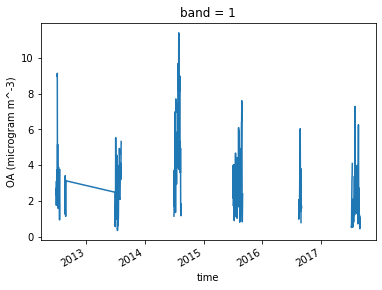

In [78]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [79]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([1.85296371, 3.42130429])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

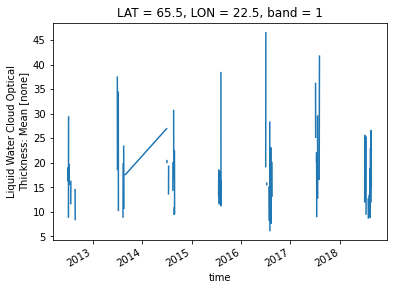

In [80]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [81]:
varsl = ['OA (microgram m^-3)', 
         'CWP (g m^-2)',
       'CER (micrometer)', 'COT','N50','N100','N200', 'T_C']

In [82]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [83]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 434, LAT: 6, LON: 8)
Coordinates:
  * time                 (time) datetime64[ns] 2012-07-01 ... 2018-08-31
  * LAT                  (LAT) float64 65.5 64.5 63.5 62.5 61.5 60.5
  * LON                  (LON) float64 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 3.065 3.065 3.065 ... nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 124.0 132.0 ... 82.0 125.0
    CER (micrometer)     (time, LAT, LON) float32 10.79 11.41 ... 12.57 13.38
    COT                  (time, LAT, LON) float32 18.18 18.75 ... 10.17 14.74
    N50                  (time) float64 1.366e+03 1.7e+03 ... 1.383e+03 828.0
    N100                 (time) float64 814.2 682.3 831.0 ... 600.9 860.2 504.9
    N200                 (time) float64 189.4 110.3 136.8 ... 63.55 177.6 110.4
    T_C                  (time) float64 19.26 18.25 19.33 20.18 ... nan nan nan

In [84]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [85]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

<AxesSubplot:xlabel='time,LAT,LON'>

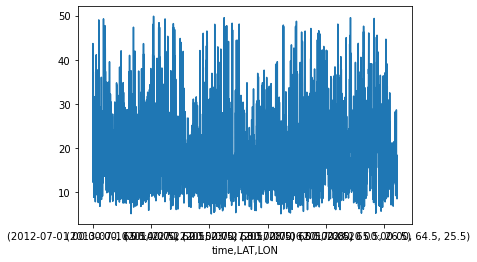

In [86]:
df_smr_sat_JAs['COT'].plot()#.dropna()

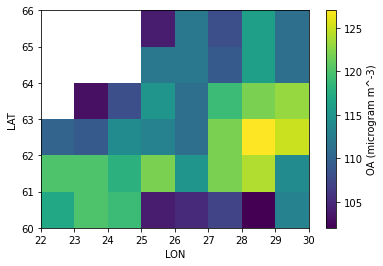

In [87]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [88]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [89]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


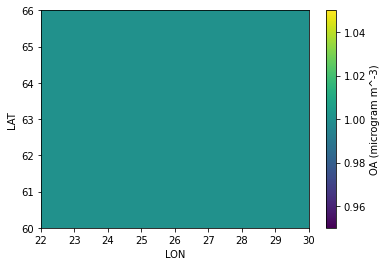

In [90]:
(~da_drop_pixels).plot()

In [91]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

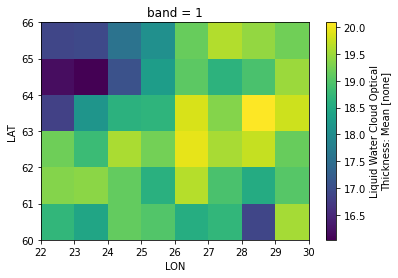

In [92]:
ds_smr_sat_JAs['COT'].mean('time').plot()

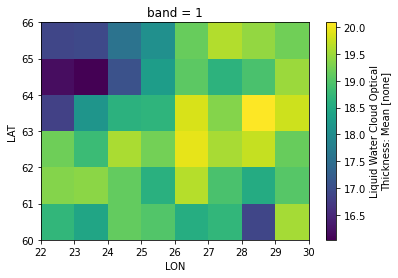

In [93]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([2448., 3504., 2400., 1680.,  672.,  384.,  336.,  336.,   48.,
          48.]),
 array([ 0.35336231,  1.45674178,  2.56012124,  3.66350071,  4.76688017,
         5.87025964,  6.97363911,  8.07701857,  9.18039804, 10.2837775 ,
        11.38715697]),
 <BarContainer object of 10 artists>)

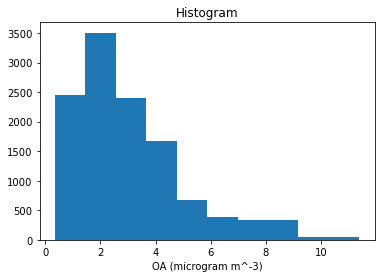

In [94]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [95]:
dic_OA_percentiles = dict()

In [96]:
ds_smr_sat_JAs

<xarray.Dataset>
Dimensions:              (time: 434, LAT: 6, LON: 8)
Coordinates:
  * LAT                  (LAT) float64 65.5 64.5 63.5 62.5 61.5 60.5
  * time                 (time) datetime64[ns] 2012-07-01 ... 2018-08-31
  * LON                  (LON) float64 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 3.065 3.065 3.065 ... nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 124.0 132.0 ... 82.0 125.0
    CER (micrometer)     (time, LAT, LON) float32 10.79 11.41 ... 12.57 13.38
    COT                  (time, LAT, LON) float32 18.18 18.75 ... 10.17 14.74
    N50                  (time, LAT, LON) float64 1.366e+03 1.366e+03 ... 828.0
    N100                 (time, LAT, LON) float64 814.2 814.2 ... 504.9 504.9
    N200                 (time, LAT, LON) float64 189.4 189.4 ... 110.4 110.4
    T_C                  (time, LAT, LON) float64 19.26 19.26 19.26 ... nan nan

ds_smr_sat_JAs['OA_high'].to_dataframe().dropna().count()

In [97]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [98]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,N50,N100,N200,T_C
time,lat,lon,,,,,,,,
2012-07-01,60.5,22.5,3.065123,NaN,NaN,NaN,1365.917038,814.156584,189.417699,19.257653
2012-07-02,60.5,22.5,1.759205,NaN,NaN,NaN,1699.667970,682.259123,110.332672,18.247258
2012-07-03,60.5,22.5,2.734630,72.0,16.09,7.680000,1825.376856,831.041943,136.791544,19.326519
2012-07-04,60.5,22.5,2.309123,NaN,NaN,NaN,1717.730613,824.067705,95.888860,20.180375
2012-07-05,60.5,22.5,3.726425,191.0,12.94,26.219999,1993.542944,1103.382904,147.253555,22.369723
...,...,...,...,...,...,...,...,...,...,...
2018-08-27,65.5,29.5,NaN,141.0,17.43,13.030000,1041.736915,316.312528,38.920027,NaN
2018-08-28,65.5,29.5,NaN,NaN,NaN,NaN,1511.480481,496.352434,58.394336,NaN
2018-08-29,65.5,29.5,NaN,NaN,NaN,NaN,1282.501151,600.943197,63.549478,NaN


df_smr_sat_JAsad model data:

## Load model data

In [99]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth'
model_name_ukesm  = 'UKESM'

models =[model_name_noresm,model_name_echam,model_name_ec_earth,model_name_ukesm]

### Settings

In [100]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

### NorESM

In [101]:


lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'

In [102]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
model_name_noresm = 'NorESM'


#### Input files created in [03-02-01-create_file.ipynb](03-02-01-create_file.ipynb)

#### Input files

In [103]:
input_path_noresm = path_extract_latlon_outdata / model_name_noresm / case_name_noresm 

In [104]:
fn_noresm     = input_path_noresm / f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = input_path_noresm / f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'


In [105]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [106]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

#### Input files:

In [107]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [108]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [109]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [110]:
cases_echam = [case_name_echam]

In [111]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [112]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [113]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [114]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [115]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [116]:
cases_ec_earth = [case_name_ec_earth]

### UKESM

In [117]:

case_name = 'AEROCOMTRAJ'
case_name_ukesm = 'AEROCOMTRAJ'
time_res = 'hour'
space_res='locations'
model_name='UKESM'
model_name_ukesm ='UKESM'

#### Define some strings for files

In [118]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [119]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm/ case_name_ukesm

In [120]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [121]:
fn_final_ukesm_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0ALL_year.csv')

In [122]:
cases_ukesm = [case_name_ukesm]

### Read in model data

In [123]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month

df_mod_ukesm = pd.read_csv(fn_final_ukesm_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ukesm['month'] =df_mod_ukesm.index.get_level_values(0).month

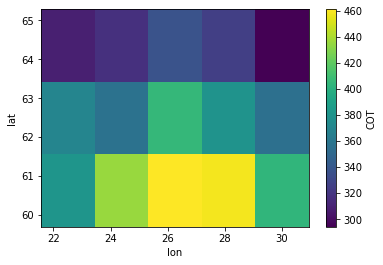

In [124]:
_ds = df_mod_echam.to_xarray()

_ds['time'] = pd.to_datetime(_ds['time'])

#_ds = _ds.where(_ds['time.month'].isin([7,8]))

_ds.count('time')['COT'].plot()

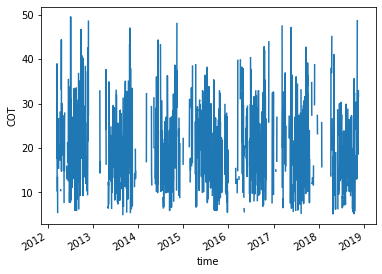

In [125]:
_ds.mean(['lat','lon'])['COT'].plot()

## Pick out months:

In [126]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]
df_mod_ukesm = df_mod_ukesm[df_mod_ukesm['month'].isin(season2month[season])]

### Organize data in dictionary

In [127]:
_df = df_hyy_1.copy()

In [128]:
df_hyy_1['month'] = df_hyy_1.index.get_level_values(0).month

In [129]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df[model_name_ukesm] = df_mod_ukesm
dic_df['Observations'] = df_hyy_1

### Rename variables:


In [130]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',


}
rn_dic_ukesm = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',


}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
    'N100_STP':'N100',
    'N50_STP':'N50',
    'N200_STP':'N200',
    'N500_STP':'N500',

}

In [131]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    model_name_ukesm:rn_dic_ukesm,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [132]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [133]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [134]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    print(mod)
    print(_rn_dic)
    for v in ['OA','N100','N50','N200','N500']:
        if (v in dic_df[mod].columns) & (f'{v}_STP' in dic_df[mod].columns):
            if (f'{v}_STP' in _rn_dic):
                if (_rn_dic[f'{v}_STP']==v):
                    dic_df[mod] = dic_df[mod].drop([v], axis=1)
                    print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

NorESM
{'TGCLDLWP_incld': 'CWP', 'TOT_CLD_VISTAU_s_incld': 'COT', 'ACTREL_incld': 'r_eff', 'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500'}
dropping OA in favor of OA_STP
ECHAM-SALSA
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500'}
EC-Earth
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500'}
UKESM
{'OA_STP': 'OA', 'N100_STP': 'N100', 'N50_STP': 'N50', 'N200_STP': 'N200', 'N500_STP': 'N500'}
dropping OA in favor of OA_STP
Observations
{'CWP (g m^-2)': 'CWP', 'CER (micrometer)': 'r_eff', 'OA (microgram m^-3)': 'OA'}


In [135]:


models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [136]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 434, lat: 3, lon: 5)
Coordinates:
  * time            (time) datetime64[ns] 2012-07-01 2012-07-02 ... 2018-08-31
  * lat             (lat) float64 60.62 62.49 64.35
  * lon             (lon) float64 22.5 24.38 26.25 28.12 30.0
Data variables: (12/54)
    station         (time, lat, lon) object 'SMR' 'SMR' 'SMR' ... 'SMR' 'SMR'
    r_eff           (time, lat, lon) float64 nan nan nan ... 8.257 nan 10.83
    ceff_um         (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 0.0 nan 0.0
    ceff            (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 0.0 nan 0.0
    CWP             (time, lat, lon) float64 nan nan nan ... 168.0 nan 307.3
    lcdnc_ct_incld  (time, lat, lon) float64 nan nan nan ... nan 4.478e+07
    ...              ...
    OA              (time, lat, lon) float64 1.266 1.266 1.266 ... 1.086 1.086
    T_C             (time, lat, lon) float64 20.32 20.32 20.32 ... 15.98 15.98
    mmrtrN100       (time, lat, lon) floa

In [137]:
model_name_echam

'ECHAM-SALSA'

## Mask data

### Moved to preprocessing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

## Group by cloud water path 

#### Predefined bins

In [138]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ukesm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:


varl_categories

In [139]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
   'N50','N100','N200',
       'OA_low', 'OA_high', 'OA_category']

### Calculate CWP and high/low categories in models

In [140]:
varl_categories = ['OA','N100','N200','N50','T_C']#,'CLDFREE']

In [141]:
varlist_notna = ['OA','CWP','COT','r_eff','N100','N200','N50','T_C']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [142]:
varlist_notna_noCOT

{'CWP', 'N100', 'N200', 'N50', 'OA', 'T_C', 'r_eff'}

In [143]:
varl_categories

['OA', 'N100', 'N200', 'N50', 'T_C']

In [144]:
def get_dic_percentiles(v, sources, dic_df):
    
    dic_v_percentiles = dict()
    for so in sources:
        df_mod = dic_df[so].copy()
        dic_var_percentiles = dict()
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        dic_v_percentiles[so] =dict()
        dic_v_percentiles[so]['33rd']=q34
        dic_v_percentiles[so]['66th']=q66
        dic_v_percentiles[so]['med_high']= df_mod[v][df_mod[v]>q66].median()
        dic_v_percentiles[so]['med_low']= df_mod[v][df_mod[v]<q34].median()
    return dic_v_percentiles

In [145]:
dic_var_percentiles = dict()

In [146]:
rndic_temp = {'HYY_META.T168':'T_C'}

In [147]:
source ='Observations'

In [148]:
dic_df[source]

,,,OA,CWP,r_eff,COT,N50,N100,N200,T_C,month
time,lat,lon,,,,,,,,,
2012-07-01,60.5,22.5,3.065123,NaN,NaN,NaN,1365.917038,814.156584,189.417699,19.257653,7
2012-07-02,60.5,22.5,1.759205,NaN,NaN,NaN,1699.667970,682.259123,110.332672,18.247258,7
2012-07-03,60.5,22.5,2.734630,72.0,16.09,7.680000,1825.376856,831.041943,136.791544,19.326519,7
2012-07-04,60.5,22.5,2.309123,NaN,NaN,NaN,1717.730613,824.067705,95.888860,20.180375,7
2012-07-05,60.5,22.5,3.726425,191.0,12.94,26.219999,1993.542944,1103.382904,147.253555,22.369723,7
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,65.5,29.5,NaN,141.0,17.43,13.030000,1041.736915,316.312528,38.920027,NaN,8
2018-08-28,65.5,29.5,NaN,NaN,NaN,NaN,1511.480481,496.352434,58.394336,NaN,8
2018-08-29,65.5,29.5,NaN,NaN,NaN,NaN,1282.501151,600.943197,63.549478,NaN,8


In [149]:
n_bins = 7

for model_name in dic_df.keys():
    
    dic_var_percentiles[model_name] = dict()

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name in ['UKESM','EC-Earth']:
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


    for v in varl_categories:
        
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()
        else:
            
            dic_var_percentiles[model_name][v] = dict()
            dic_var_percentiles[model_name][v]['33rd']=q34
            dic_var_percentiles[model_name][v]['66th']=q66
            dic_var_percentiles[model_name][v]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_var_percentiles[model_name][v]['med_low']= df_mod[v][df_mod[v]<q34].median()
            
        
        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    
    
    
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)

    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.534073425
0.982132035
97.786828197268
180.527130262822
17.876301565484997
34.87084040024998
318.041311738795
540.034038115234
16.8842165
19.35318
NorESM
0.8006639996389435
1.3830742313377318
207.92809377663218
370.9494937279485
24.23389112816425
53.70221145788181
1000.7199481933836
1557.715350004838
14.6420745
17.933716
EC-Earth
2.228140261105776
4.031359827583868
287.9239773987796
475.61617527158495
114.5338448634937
185.22952578665357
538.1566765075013
863.7520345458255
17.7822265
19.871292


/tmp/ipykernel_2618055/524478787.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2618055/524478787.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2618055/524478787.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2618055/52447878

UKESM
1.163166996608385
2.131171790120335
442.70821992502187
692.220808415161
215.13407542386275
350.72572269599084
499.78676767290455
763.531093728874
17.002838
19.588531
Observations
1.6647118331206672
2.9470083484495393
344.0178949535533
626.2559961687639
73.78039389238103
143.61478410639768
840.7715140485507
1263.9655984305462
16.175690416666665
18.24725833333333


In [150]:
dic_var_percentiles_rev = dict()
for v in varl_categories:
    if v =='OA':
        continue
    dic_var_percentiles_rev[v]=dict()
    for model_name in dic_var_percentiles.keys():
        print(model_name)
        dic_var_percentiles_rev[v][model_name]=dic_var_percentiles[model_name][v]

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


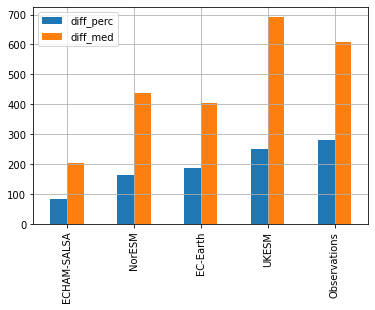

In [151]:
v='N100'
_diff_vx = pd.DataFrame(dic_var_percentiles_rev[v]).T
_diff_vx['diff_perc'] = _diff_vx['66th']-_diff_vx['33rd']
_diff_vx['diff_med'] = _diff_vx['med_high']-_diff_vx['med_low']
_diff_vx[['diff_perc','diff_med']].plot.bar()
plt.grid()

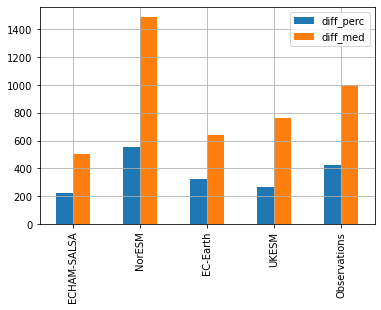

In [152]:
v='N50'
_diff_vx = pd.DataFrame(dic_var_percentiles_rev[v]).T
_diff_vx['diff_perc'] = _diff_vx['66th']-_diff_vx['33rd']
_diff_vx['diff_med'] = _diff_vx['med_high']-_diff_vx['med_low']
_diff_vx[['diff_perc','diff_med']].plot.bar()
plt.grid()

<AxesSubplot:>

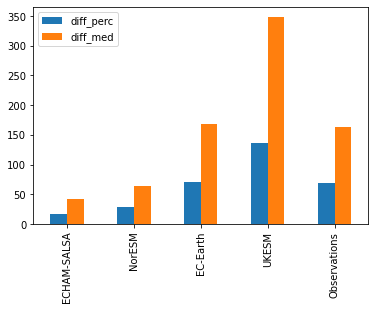

In [153]:
v='N200'
_diff_vx = pd.DataFrame(dic_var_percentiles_rev[v]).T
_diff_vx['diff_perc'] = _diff_vx['66th']-_diff_vx['33rd']
_diff_vx['diff_med'] = _diff_vx['med_high']-_diff_vx['med_low']
_diff_vx[['diff_perc','diff_med']].plot.bar()

In [154]:

OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn) 
OA_percentile_df

Plots/cloud_props_Nx__percentile_OA_OA_perc_JA.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.534073,0.982132,1.380092,0.374948,0.448059
NorESM,0.800664,1.383074,2.146761,0.565120,0.582410
EC-Earth,2.228140,4.031360,5.576182,1.534846,1.803220
UKESM,1.163167,2.131172,3.133496,0.833350,0.968005
Observations,1.664712,2.947008,3.901629,1.109301,1.282297


<AxesSubplot:>

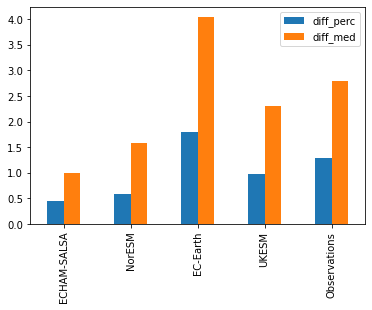

In [155]:
OA_percentile_df['diff_perc'] = OA_percentile_df['66th']-OA_percentile_df['33rd']
OA_percentile_df['diff_med'] = OA_percentile_df['med_high']-OA_percentile_df['med_low']
OA_percentile_df[['diff_perc','diff_med']].plot.bar()

## Quantile cut

In [156]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [157]:
palette = 'Set2'

In [158]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

5221
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_COT_hue_N50_count_JA.png


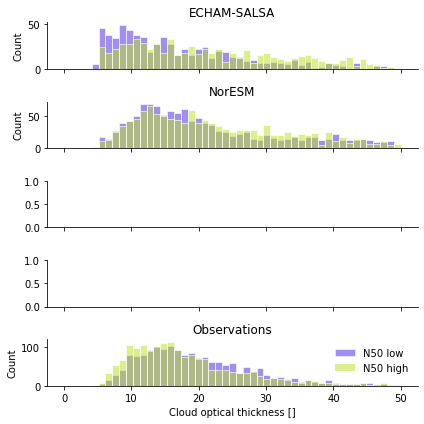

In [159]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'N50'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key in ['EC-Earth','UKESM']:
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness []')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', f'{v_x}_hue_{v_hue}','count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



5203
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_CWP_hue_N50_count_JA.png


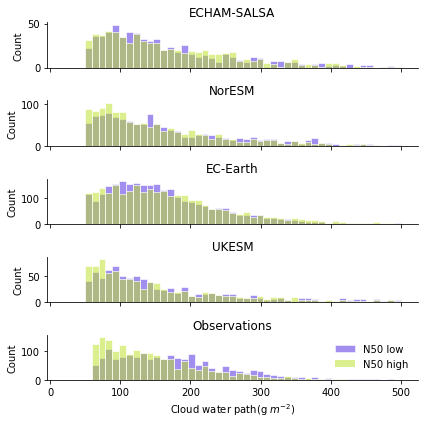

In [160]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 500
v_hue = 'N50'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(20,500)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', f'{v_x}_hue_{v_hue}','obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', f'{v_x}_hue_{v_hue}','count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



<AxesSubplot:ylabel='Frequency'>

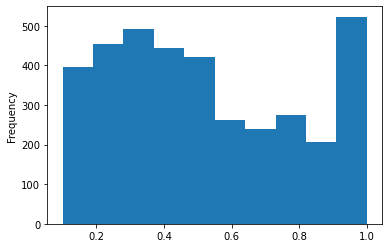

In [161]:
_df = dic_df['NorESM']
_df['FCTL'].plot.hist()

In [162]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

2022

2022
3710
8214
2720
5221
Plots/dist_plot/cloud_props_Nx_distribution_mod_obs_r_eff_hue_N50_count_JA.png


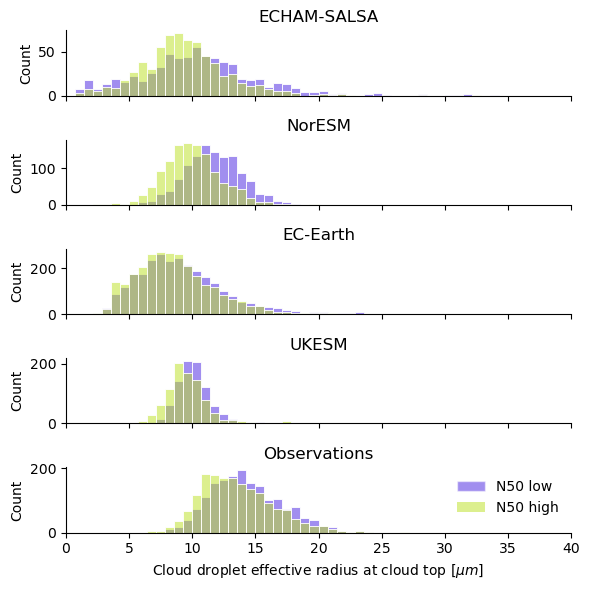

In [163]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'N50'
v_hue_cat = f'{v_hue}_category'
hue_order=[f'{v_hue} low', f'{v_hue} high'][::-1]
_bins = np.linspace(0,35)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue_cat,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label=f'{v_hue} low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label=f'{v_hue} high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', f'{v_x}_hue_{v_hue}','obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', f'{v_x}_hue_{v_hue}','count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



# Calculate difference between high OA and low


In [164]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [165]:
palette_OA_2 = palette_OA[::-1]

In [166]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [167]:
from sklearn.utils import resample

## Bootstrap resampling 

In [168]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [169]:
hue_var = 'T_C'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']
hue_var_orig = hue_var.split('_')[0]

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    #dic_var_percentiles = get_dic_percentiles(hue_var_orig,dic_df.keys(), dic_df)
    
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var_cat].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var_cat].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var_cat] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var_cat] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()[hue_var_cat]
        n_high = _df_high.groupby(x_var).count()[hue_var_cat]
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
        #hue_high_med = dic_var_percentiles[key]['med_high']
        #hue_low_med = dic_var_percentiles[key]['med_low']
        #hue_high_low_diff = hue_high_med -hue_low_med
        diff_med = (med_high-med_low)#/hue_high_low_diff
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
267
length of 75 is 140 and 218
number of days is 80 and 111
1000
length of 118 is 162 and 168
number of days is 82 and 91
1000
length of 159 is 106 and 111
number of days is 71 and 69
1000
length of 206 is 85 and 63
number of days is 56 and 46
1000
length of 253 is 61 and 43
number of days is 45 and 32
1000
length of 295 is 46 and 31
number of days is 37 and 26
1000
length of 382 is 70 and 36
number of days is 39 and 27
1000
NorESM
Total number of days:
225
length of 72 is 270 and 487
number of days is 56 and 129
1000
length of 112 is 234 and 291
number of days is 63 and 99
1000
length of 154 is 221 and 180
number of days is 60 and 74
1000
length of 199 is 134 and 104
number of days is 47 and 54
1000
length of 241 is 99 and 55
number of days is 40 and 36
1000
length of 287 is 90 and 47
number of days is 32 and 29
1000
length of 365 is 171 and 72
number of days is 39 and 28
1000
EC-Earth
UKESM
Observations
Total number of days:
153
length of 79 is 271 

In [170]:
v = 'COT'
v_hue = 'T_C'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    #_df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())
    print(fn)



ECHAM-SALSA
-2.0429825354477598
Plots/cloud_props_Nx_ECHAM-SALSA_sample_stats_T_C_COT_JA.csv
NorESM
1.9861844745417525
Plots/cloud_props_Nx_NorESM_sample_stats_T_C_COT_JA.csv
Observations
0.7447060931737046
Plots/cloud_props_Nx_Observations_sample_stats_T_C_COT_JA.csv


In [171]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', v_hue,v, comment=source).with_suffix('.csv')
    #_df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


# Final plot: 

Plots/rel_plot/cloud_props_Nx_r_eff_diff_median_T_C_COT_CWP_cut2lm_JA.png


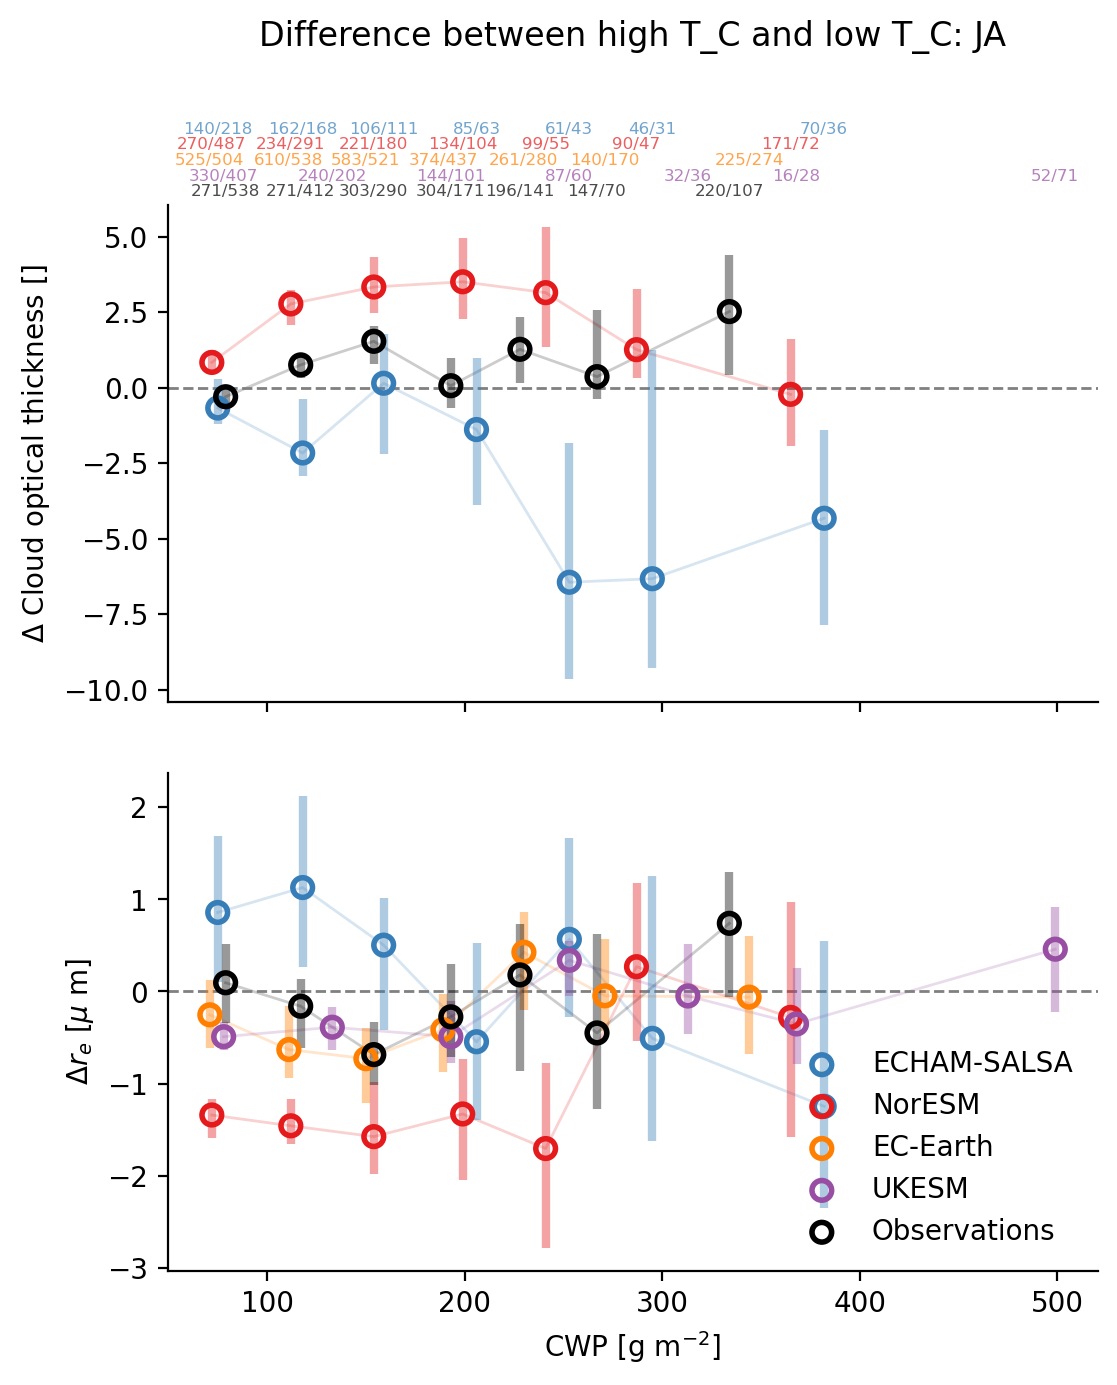

In [172]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4

hue_var = 'T_C'
hue_var_cat = f'{hue_var}_category'
hue_labs = [f'{hue_var} low', f'{hue_var} high']

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high {v_hue} and low {v_hue}: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg